# Chapter 7: Conditional GAN and Wasserstein GAN




***
“??.”


-- ??
***

The Anime faces we generated in Chapter 6 look realistic. However, you may have noticed that the hair colors are different in the generated images: some have black hair, some have red hair, and some have other colors. You may wonder: what if we want to generate Anime faces with a certain hair color, say, brown? It turns out you can and in this chapter, you'll learn how to implement the conditional GAN. In conditional GAN, we train the model on labeled data and ask the trained model to generate data with a sepcific label. 

In this chapter, we'll train the model on color images of human faces with two different labels: those with eye glasses and those without eye glasses. When training the model, we add two channels to the three-channnel color images: the two channels are one-hot encoded labels of the images. When generating new images, the generator samples from the latent space and obtains an image label. The generator then creates an image based on the image type: either with eye glasses or without. 

Further, while the Anime faces we generated in Chapter 6 look realistic, they are nowhere nearly being perfect. Training GAN models are difficult. In many situations, due to various reasons, such as sample size and sample quality, models never converge and the gererated images are of poor quality. Researchers have proposed ways to improve the training process by proposing different loss functions. In this chapter, we'll discuss the Wasserstein distance and the gradient penalty as ways to improve the trainig process for GANs. We'll then implement it on the training process in this chapter so that the generated human faces are realistic.  

Start a new cell in ch07.ipynb and execute the following lines of code in it:

In [16]:
import os

os.makedirs("files/ch07", exist_ok=True)

# 1. The Eye Glasses Dataset
We'll use the eye glasses dataset in this chatper to train the conditional GAN model. Further, in the next chapter, we'll also use this dataset to trin a Cycle GAN model: to convert an image with eye glasses to an image with glasses and vice versa. 

## 1.1 Download the Dataset
The dataset is from the Kaggle project by Yashika Jain https://www.kaggle.com/code/yashikajain/eye-glass-removal. Go to Kaggle and download the dataset associated with the project. The dataset has two csv files train.csv and test.csv. Further, there are 5000 images in the folder /faces-spring-2020/. Once you have the data, place both the image folder and the two csv files inside /Desktop/ai/files/ch07/ on your computer. 

Next, we'll sort the photos into two subfolders: with glasses and without glasses. 

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pandas as pd
import shutil

train = pd.read_csv('files/ch07/train.csv')
train.set_index('id', inplace=True)

The above code cell imports the file *train.csv* and set the variable *id* as the index of each observation. The column *glasses* in the file has two values: 0 or 1, where 0 indicates the image has no glasses and 1 indicates the image has glasses. 

In [2]:
print(train["glasses"])

id
1       0
2       1
3       1
4       0
5       0
       ..
4496    0
4497    0
4498    1
4499    1
4500    0
Name: glasses, Length: 4500, dtype: int64


we print out the values of the column *glasses* in the file *train.csv*. The values are either 0 or 1 and there are a total of 4500 observations. 

We'll create two subfolders /G/ and /NoG/ and separate the images into two the two folders. The folder /G/ contains images with glasses while /NoG/ contains images without glasses. 

In [ ]:
# create two subfolders
G='files/ch07/data/G/'
NoG='files/ch07/data/NoG/'
os.makedirs(G,exist_ok=True)
os.makedirs(NoG,exist_ok=True)
folder='files/ch07/faces-spring-2020/faces-spring-2020/'
for i in range(1,4501):
    # see if the label  is 0 or 1
    if train.loc[i]['glasses']==0:
        # move to folder NoG if label is 0
        oldpath=f"{folder}face-{i}.png"
        newpath=f"{NoG}face-{i}.png"
        shutil.move(oldpath, newpath)
    if train.loc[i]['glasses']==1:
        # move to folder G if label is 1
        oldpath=f"{folder}face-{i}.png"
        newpath=f"{G}face-{i}.png"
        shutil.move(oldpath, newpath)

## 1.2 Clean Up the Dataset
The classification is not perfect. If you go to the subfolder /G/, for example, you'll see that most images have glasses, but about 10% of them have no glasses. Similarly, if you go to /NoG/, you'll see that about 10% of them actually have glasses. I manually corrected this but moving images from one folder to the other. This is important for our training later. 

Next, we'll show some examples of each type of images:

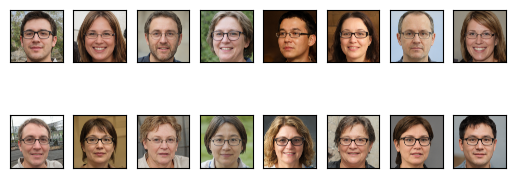

In [10]:
import random
import matplotlib.pyplot as plt
from PIL import Image

imgs=os.listdir(G)
samples=random.sample(imgs,16)
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    img=Image.open(f"{G}{samples[i]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=-0.6)
plt.show()   

If you have corrected the mislabeling of the images, you should see all 16 iamges with glasses from above. Below, we plot 16 images without glasses:

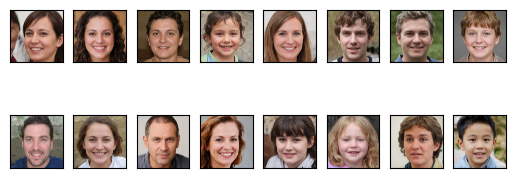

In [6]:
imgs=os.listdir(NoG)
samples=random.sample(imgs,16)
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    img=Image.open(f"{NoG}{samples[i]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=-0.6)
plt.show() 

The output shows 16 images without glasses. 

# 2. The Conditional GAN Model
Wasserstein GAN and Conditional GAN or different concepts. Wasserstein GAN is to use the Wasserstein distance to improve the trainig process, and it can apply to any GAN models. Conditional GAN is a GAN model in which we can tell the generator what style of output to generate. To save time, we'll discuss both in this chapter and implement the Wasserstein distance in our conditional GAN model. 

## 2.1. The Wasserstein Distance
As we discussed in earlier chapters, when training the GAN models, we are trying to learn the true distribution of the real data $P_r(x)$, which is not directly observable. The model is trying to approximate the distribution using  $P_g(x)$ and gererating images by sampling from the distribution $P_g(x)$. The closer the distribution $P_g(x)$ to the true distribution $P_r(x)$, the more realistic the generated images are. 

A research paper by Arjovsky et al in 2017 proposes a method to minimize the Wasserstein distance to improve the estimating process. Wasserstein distance is the minimum work needed to transform one distribution to another. In terms of implementation, the discriminator will estimate the the Wasserstein distance between the two distributions $P_r(x)$ and $P_g(x)$, instead of estimating the probability that a given image is real. To ensure smooth training, Arjovsky et al in 2017 proposes weight clipping so the critic value is not too large or too small. An alternative approach is to use gradient penalty, and we'll use the latter apporach. 

## 2.2. A Critic in Wasserstein CGAN
The critic is not a binary classifier. Instead, it evaluates the image and gives a score between $-\infty$ and $\infty$. The higher the score, the better the quality of the image. The structure of the critic neural network is as follows:

In [8]:
import torch.nn as nn
import torch

# determine the device automatically
device = "cuda" if torch.cuda.is_available() else "cpu"
class Critic(nn.Module):
    def __init__(self, img_channels, features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, features, 
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.block(features, features * 2, 4, 2, 1),
            self.block(features * 2, features * 4, 4, 2, 1),
            self.block(features * 4, features * 8, 4, 2, 1),
            self.block(features * 8, features * 16, 4, 2, 1),  
            self.block(features * 16, features * 32, 4, 2, 1),            
            nn.Conv2d(features * 32, 1, kernel_size=4,
                      stride=2, padding=0))

    def block(self, in_channels, out_channels, 
              kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2))

    def forward(self, x):
        return self.net(x)

The input to the discriminator model is a color image with a shape of 5 by 64 by 64. The first three channels are color channels RGB. The last two channels are labeling channels to tell the critic whether the image is with glasses or without glasses. We'll discuss the exact mechnism to accomplish this in the next section. 

Another key point to keep in mind is the output is no longer a value between 0 and 1 since we don't use the sigmoid activation in the last layer in the critic model. Instead, the output is a value between between $-\infty$ and $\infty$.

## 2.3. The Generator in Conditional GAN
The generator G's job is to create an image so that it can be evaluated ast a higher score by the critic. Further, the generator must know whehter to generate an image with or without glasses. We'll tell the generator the labeling information by attaching to the latent space information a one-hot variable indicating if the image we want has glasses or not. We'll discuss the exact mechanims in the next section. 

We create the following neural network to respresent the generator G:

In [9]:
class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels, features):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self.block(noise_channels, features *64, 4, 1, 0),
            self.block(features * 64, features * 32, 4, 2, 1),
            self.block(features * 32, features * 16, 4, 2, 1),
            self.block(features * 16, features * 8, 4, 2, 1),
            self.block(features * 8, features * 4, 4, 2, 1),            
            self.block(features * 4, features * 2, 4, 2, 1),            
            nn.ConvTranspose2d(
                features * 2, img_channels, kernel_size=4,
                stride=2, padding=1
            ),
            nn.Tanh())
    def block(self, in_channels, out_channels, 
              kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.net(x)

We'll feed random data from a 100-dimensional latent space, $(z_1, z_2, ..., z_{100})$, to the generator. We'll also feed a two-dimensional onehot encoded image label to the generator. For simplicity, we'll concatente the two pieces of information together to form a 102-dimensional input variable to the generator. The generator then generates a color image with values between -1 and 1 based on the input from the latent space and the labeling information. As always, we use the Tanh activation function at the output layer so the output are all in the range of -1 and 1, the same as the training images. 

In the function, we create an interpolcated image of the real and the fake image. We apply a penalty if the gradient norm moves away form the target value of 1. 

Below, we create a critic and a generator as follows:

In [ ]:
gen=Generator(z_dim+2,img_channels,features).to(device)
critic=Discriminator(img_channels+2,features).to(device)

We also initiate the weights for both the generator and the cirtic:

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)    
weights_init(gen)
weights_init(critic)

## 2.4. The Gradient Penalty Function

As usual, we'll use the Adam optimizer for both the critic and the generator:

In [10]:
lr = 0.0001
opt_gen = torch.optim.Adam(gen.parameters(), 
                         lr = lr, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(), 
                         lr = lr, betas=(0.0, 0.9))

Instead of using a direct loss function, the geneator will maximize the rating by the critic (or equivalently, minimize the negative evaluation). The objective of the critic is as follows:
$$min\ critic\_value(fake\_image)-critic\_value(real\_image)+weight*GradientPenalty$$

If an image is fake, the critic's objective is to identify it as fake and give a low evaluation; if the image is real, the critic's objective is to identify it as real and give a high evaluation. Further, the critic wants to minimize the gradient penalty, which is calculated as follows:

In [ ]:
def GP(critic, real, fake):
    B, C, H, W = real.shape
    alpha=torch.rand((B, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)
    critic_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=critic_scores,
        grad_outputs=torch.ones_like(critic_scores),
        create_graph=True,
        retain_graph=True)[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gp = torch.mean((gradient_norm - 1) ** 2)
    return gp

In the function, we create an interpolcated image of the real and the fake image. We apply a penalty if the gradient norm moves away form the target value of 1. 



# 3. Prepare the Training Data
As we mentioned in the last section, we need to find a way to tell both the critic and the generator what's the image's label. 

## 3.1. Transform the Data
We first preprocess the data and convert the images to torch tensors, as follows:

In [ ]:
import torchvision.transforms as T

batch_size=16
imgsz=256
transform=T.Compose([
    T.Resize((imgsz,imgsz)),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])      
data_set=torchvision.datasets.ImageFolder(
    root=r"files/ch07/data",
    transform=transform) 

We set the batch size to 16, less than the batch size we used in the last two chatpers. This is because we want to generate high quality images: the images we use are 256 by 256 pixels, instead of the 64 by 64 pixels we used in the past two chapters. If we set the batch size too large, the GPU will run out of memory. 

## 3.2. Add Labels to the Data
Now we can add labels to the training data so that both the critic and the generator know the image labels. 

In regular DCGAN, we feed the discriminator a three-channel image. Here we have two labels: with and without glasses. We'll create onehot image labels: images with glasses will have a onehot label of [1, 0] and images without glasses will have a onehot label of [0, 1]. However, since the images we use in this chapter are 256 by 256, we'll change the image shape from 3 by 256 by 256 to 5 by 256 by 256: the two additional channels are the onehot labels.

In [ ]:
import torchvision

newdata=[]
for i,(img,label) in enumerate(data_set):
    onehot=torch.zeros((2))
    onehot[label]=1
    channels=torch.zeros((2,imgsz,imgsz))
    if label==0:
        channels[0,:,:]=1
    else:
        channels[1,:,:]=1    
    img_and_label=torch.cat([img,channels],dim=0)    
    newdata.append((img,label,onehot,img_and_label))

Now each observation has four values: *img* is the original color image with a shape of (3,256,256); *label* is an integer with a value of 0 or 1; *onehot* is a onehot varaible with value [1, 0] or [0, 1]; *img_and_label* is image and label concatenated togther in the shape of (5,256,256). Later, we'll concatenate the variable *onehot* with the values from the latent space and feed the combined data to the generator. 

Finally, we create a data iterator with batches, as follows:

In [ ]:
data_loader=torch.utils.data.DataLoader(
    newdata,batch_size=batch_size,shuffle=True)

# 4. Train the Conditional GAN
Now that we have the training data and two networks, we'll train the model. After that, we'll discard the discriminator and use the generator to generate images with a certain label (with or without glasses). 

## 4.1. Test Ouput Periodically During Training
We'll crate a function to test what the fake images generated by G look like. 

In [11]:
def test(epoch):
    # test images with glasses
    noise = torch.randn(32, z_dim, 1, 1)
    labels = torch.zeros(32, 2, 1, 1)
    # use label [1,0] so G knows what to generate
    labels[:,0,:,:]=1
    noise_and_labels=torch.cat([noise,labels],dim=1).to(device)
    fake=gen(noise_and_labels).cpu().detach()
    fig=plt.figure(figsize=(20,10),dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f"files/ch07/glasses{epoch}.png")
    plt.show() 
    # test iamges without glasses
    noise = torch.randn(32, z_dim, 1, 1)
    labels = torch.zeros(32, 2, 1, 1)
    # use label [0,1] so G knows what to generate
    labels[:,1,:,:]=1
    noise_and_labels=torch.cat([noise,labels],dim=1).to(device)
    fake=gen(noise_and_labels).cpu().detach()
    fig=plt.figure(figsize=(20,10),dpi=100)
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.savefig(f"files/ch07/noglasses{epoch}.png")
    plt.show()     

When testing, we ask G to first generate 32 images with glasses. To do that, G first draws 32 100-dimensional variables from the latent space. We then concatenate 32 onehot variables [1,0] to the them so G knows to generate images with glasses. We then plot the 32 images in four rows and eight columns. 

After that, we ask G to first generate 32 images without glasses. G also draws 32 100-dimensional variables from the latent space and concatenates 32 onehot variables [0,1] to generate images without glasses. We then plot the 32 images in four rows and eight columns. 

## 4.2. Train the CGAN Model
We first define a *train_batch()* function as follows:

In [13]:
def train_batch(onehots,img_and_labels,epoch):
    real = img_and_labels.to(device)
    B = real.shape[0]
    # train critic five times
    for _ in range(5):
        noise = torch.randn(B, z_dim, 1, 1)
        onehots=onehots.reshape(B,2,1,1)
        noise_and_labels=torch.cat([noise,onehots],dim=1).to(device)
        fake_img = gen(noise_and_labels).to(device)
        fakelabels=img_and_labels[:,3:,:,:].to(device)
        fake=torch.cat([fake_img,fakelabels],dim=1).to(device)
        critic_real = critic(real).reshape(-1)
        critic_fake = critic(fake).reshape(-1)
        gp = GP(critic, real, fake)
        loss_critic=(-(torch.mean(critic_real) - 
           torch.mean(critic_fake)) + 10 * gp)
        critic.zero_grad()
        loss_critic.backward(retain_graph=True)
        opt_critic.step()
    # train G
    gen_fake = critic(fake).reshape(-1)
    loss_gen = -torch.mean(gen_fake)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    return loss_critic, loss_gen

We now train the model for 100 epochs, as follows:

In [ ]:
for epoch in range(1,101):
    closs=0
    gloss=0
    for _,_,onehots,img_and_labels in data_loader:    
        # train a batch
        loss_critic, loss_gen = train_batch(onehots,\
                                img_and_labels,epoch)   
        closs+=loss_critic
        gloss+=loss_gen
    print(f"at epoch {epoch},\
    critic loss: {closs}, generator loss {gloss}")
    test(epoch)
    torch.save(gen.state_dict(),f'files/ch07/cgan{epoch}.pth')

After each epoch of trainig, we print out the critic loss and the generator loss. We also generate 32 images of faces with glasses as well as 32 images without glasses, by using the *test()* function we defined earlier. We also save the state dictionaries of the generator so that later we can generate images throughout the training process.  

# 5. Animate the Training Process
We'll first generate iamges by using the trained model. We'll also animate different stages of 

## 5.1. Test the Trained Model
We'll use the trained model to first generate 32 images with glasses, as follows: 

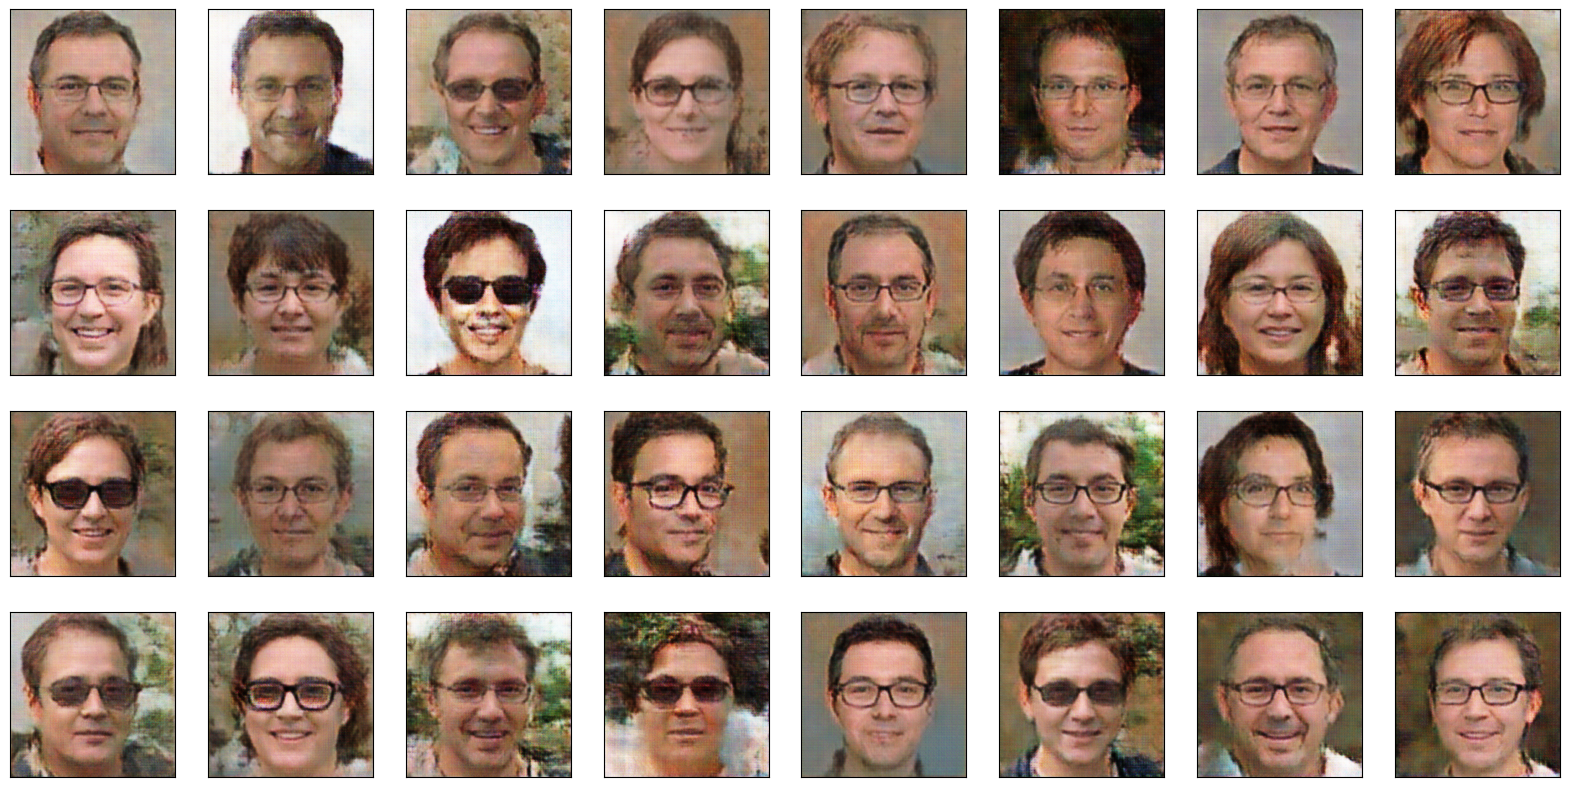

In [4]:
noise = torch.randn(32, z_dim, 1, 1)
labels = torch.zeros(32, 2, 1, 1)
labels[:,0,:,:]=1
noise_and_labels=torch.cat([noise,labels],dim=1).to(device)
fake=gen(noise_and_labels).cpu().detach()
plt.figure(figsize=(20,10),dpi=100)
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
    plt.imshow(img.numpy().repeat(4,axis=0).repeat(4,axis=1))
    plt.xticks([])
    plt.yticks([])
plt.show()

The above output shows 32 high resolution human face images with glasses.

Next, we'll generate 32 images without glasses, as follows: 

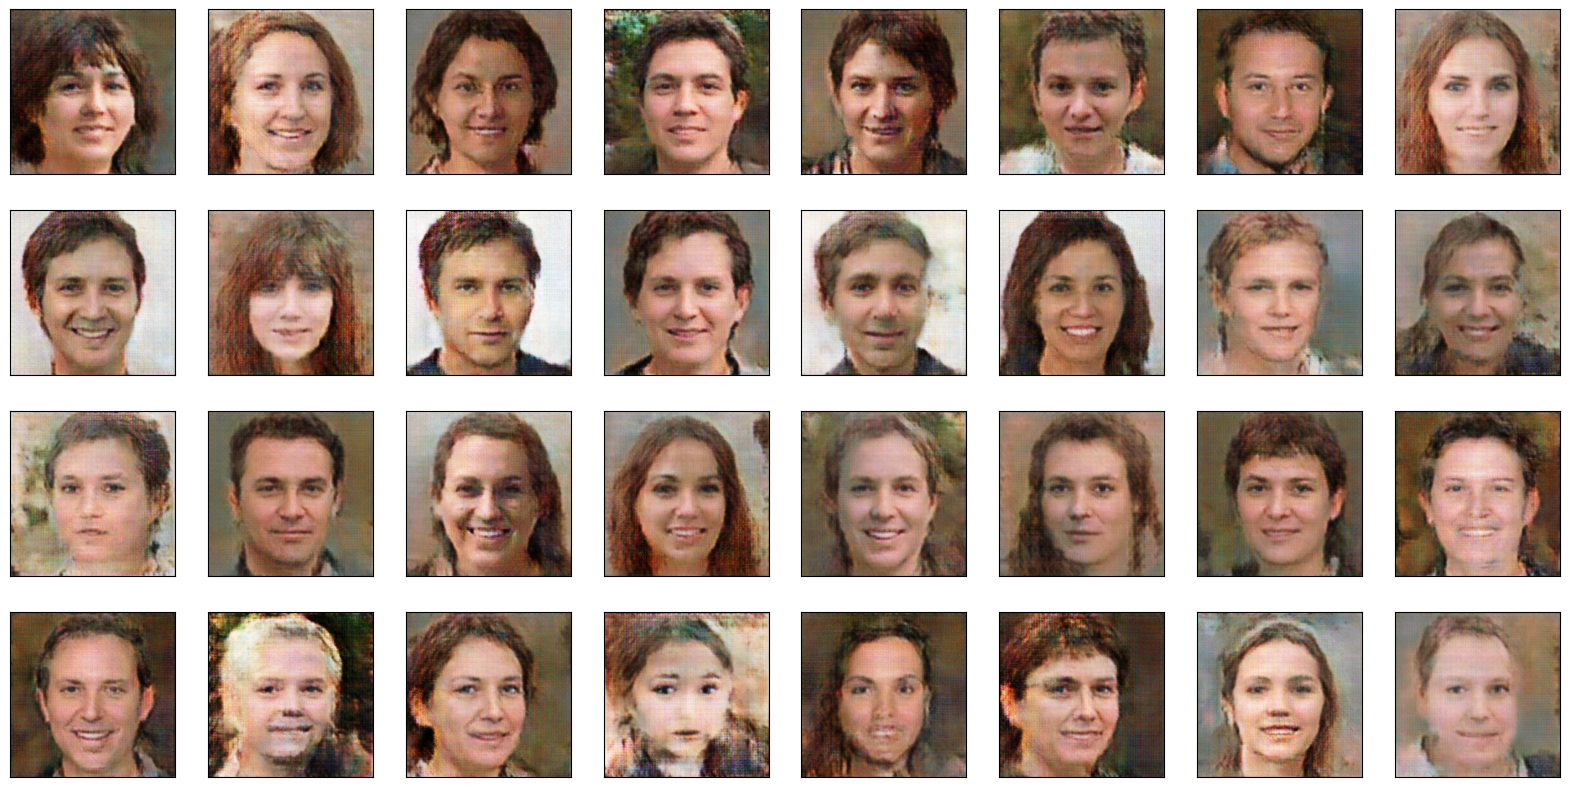

In [7]:
noise = torch.randn(32, z_dim, 1, 1)
labels = torch.zeros(32, 2, 1, 1)
labels[:,1,:,:]=1
noise_and_labels=torch.cat([noise,labels],dim=1).to(device)
fake=gen(noise_and_labels).cpu().detach()
plt.figure(figsize=(20,10),dpi=100)
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=(fake.cpu().detach()[i]/2+0.5).permute(1,2,0)
    plt.imshow(img.numpy().repeat(4,axis=0).repeat(4,axis=1))
    plt.xticks([])
    plt.yticks([])
plt.show()     

None of the above output has glasses. 

## 5.2. Animate the Training Process
We'll generate one set of images after each epoch and then combine them into a *gif* file so we can see the animation. First, we create an animation for images without glasses, like this:

In [ ]:
import imageio

combined = []
for step in range(1,101):    
    fig = plt.figure(figsize=(12,6), dpi=100)
    ax = fig.add_subplot(111) 
    ax.set_xlim(-6,6)
    ax.set_ylim(-3,3)
    #plt.grid()
    plt.axis("off")
    plt.text(-4.5,3.55,f"\
             Faces Without Glasses, Epoch {step}",fontsize=20)
    # Add the frame from the random-move game to the left
    newax = fig.add_axes([0.01,-0.01,0.98,0.96])
    img=PIL.Image.open(f"files/ch07/noglasses{step}.png")
    img=np.array(img)[50:-50,50:-50,:]
    newax.imshow(img.repeat(4,axis=0).repeat(4,axis=1))
    newax.axis('off') 
    # plot the picture 
    fig.canvas.draw()
    twoframes = np.frombuffer(fig.canvas.tostring_rgb(),
                              dtype=np.uint8)
    twoframes = twoframes.reshape(
        fig.canvas.get_width_height()[::-1]+ (3,))
    combined.append(twoframes)
    plt.close(fig)
imageio.mimsave("files/ch07/noglasses.gif",combined,duration=200)

The generated animation is as follows:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/noglasses.gif" />

In [ ]:
combined = []
for step in range(1,101):    
    fig = plt.figure(figsize=(12,6), dpi=100)
    ax = fig.add_subplot(111) 
    ax.set_xlim(-6,6)
    ax.set_ylim(-3,3)
    #plt.grid()
    plt.axis("off")
    plt.text(-4.5,3.55,f"\
                Faces With Glasses, Epoch {step}",fontsize=20)
    # Add the frame from the random-move game to the left
    newax = fig.add_axes([0.01,-0.01,0.98,0.96])
    img=PIL.Image.open(f"files/ch07/glasses{step}.png")
    img=np.array(img)[50:-50,50:-50,:]
    newax.imshow(img.repeat(4,axis=0).repeat(4,axis=1))
    newax.axis('off') 
    # plot the picture 
    fig.canvas.draw()
    twoframes = np.frombuffer(fig.canvas.tostring_rgb(),
                              dtype=np.uint8)
    twoframes = twoframes.reshape(
        fig.canvas.get_width_height()[::-1]+ (3,))
    combined.append(twoframes)
    plt.close(fig)
imageio.mimsave("files/ch07/glasses.gif",combined,duration=200)

The generated animation is as follows:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/glasses.gif" />